# Common DL techniques





Techniques used in this notebook:

- Data normalization
- Data augmentation
- Residual connections
- Batch normalization
- Learning rate scheduling
- Weight Decay
- Gradient clipping
- Adam optimizer

In [ ]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

## Preparing the CIFAR10 Dataset

In [ ]:
# Dowload the dataset
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url, '.')

# Extract from archive
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')

100%|██████████| 135107811/135107811 [00:03<00:00, 39780054.93it/s]


1. **Use test set for validation**: Instead of setting aside a fraction (e.g. 10%) of the data from the training set for validation, we'll simply use the test set as our validation set. This just gives a little more data to train with. In general, once you have picked the best model architecture & hypeparameters using a fixed validation set, it is a good idea to retrain the same model on the entire dataset just to give it a small final boost in performance.
2. **Channel-wise data normalization**: We will normalize the image tensors by subtracting the mean and dividing by the standard deviation across each channel. As a result, the mean of the data across each channel is 0, and standard deviation is 1. Normalizing the data prevents the values from any one channel from disproportionately affecting the losses and gradients while training, simply by having a higher or wider range of values that others.

<img src="https://i.imgur.com/LYxXBVg.png" width="360">


3. **Randomized data augmentations**: We will apply randomly chosen transformations while loading images from the training dataset (e.g. pad each image by 4 pixels, and then take a random crop of size 32 x 32 pixels).

Since the transformation will be applied randomly and dynamically each time a particular image is loaded, the model sees slightly different images in each epoch of training, which allows it generalize better.

![data-augmentation](https://imgaug.readthedocs.io/en/latest/_images/cropandpad_percent.jpg)

In [ ]:
# Data transforms (normalization & data augmentation)
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) # means and SD's for 3 channels

# Use tt.Compose to combine all transformations
train_tfms = tt.Compose([tt.RandomCrop(32, padding=4, padding_mode='reflect'), # crop a 32*32 image after adding paddding (4px wide, pad with reflected regions near edges)
                         tt.RandomHorizontalFlip(), # 50% chance of horizontal flip
                         # tt.RandomRotate
                         # tt.RandomResizedCrop(256, scale=(0.5,0.9), ratio=(1, 1)),
                         # tt.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                         tt.ToTensor(),
                         tt.Normalize(*stats,inplace=True)]) # normalize with 'stats'

# For validation set, do NOT apply random transformations. Otherwise, the evaluation results in different training epochs will not be comparable!
# Remember to normalize the images in the validation set with the same stats (the model is trained on normalized images)
valid_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

# PyTorch datasets
data_dir = './data/cifar10'
train_ds = ImageFolder(data_dir+'/train', train_tfms) # we use the entire training set instead of splitting the data like in previously notebook
valid_ds = ImageFolder(data_dir+'/test', valid_tfms) # we use the test set for validation

# PyTorch data loaders
batch_size = 400
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=3, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
# To display the images, we'll need to denormalize the pixels values to bring them back into the range (0,1).
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

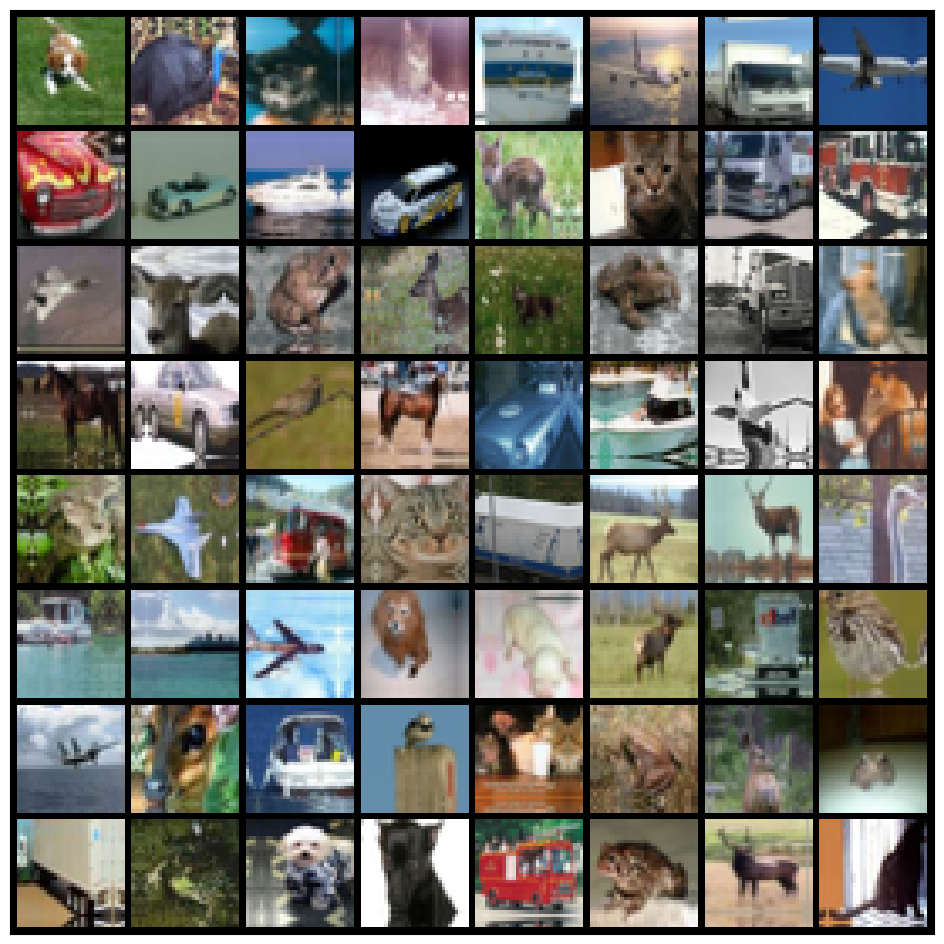

In [ ]:
show_batch(train_dl)

# Note that normalization is also applied during inference.
# If you look closely, you can see the cropping and reflection padding in some of the images.

## Using a GPU

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

## Model with Residual Blocks and Batch Normalization

Adding resudial blocks:
![](https://miro.medium.com/max/1140/1*D0F3UitQ2l5Q0Ak-tjEdJg.png)
[source](https://towardsdatascience.com/residual-blocks-building-blocks-of-resnet-fd90ca15d6ec)

After each convolutional layer, we'll also add a batch normalization layer, which normalizes the outputs of the previous layer. This is somewhat similar to data normalization, except it's applied to the outputs of a layer, and the mean and standard deviation are learned parameters. [Learn more](https://towardsdatascience.com/batch-normalization-and-dropout-in-neural-networks-explained-with-pytorch-47d7a8459bcd)

In [ ]:
# Example

class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()              # ^^^ no. of output channels must be equal to the no. of input channels, otherwise the residual can not be added to the output!

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out) + x # ReLU can be applied before or after adding the input

In [ ]:
simple_resnet = to_device(SimpleResidualBlock(), device)

for images, labels in train_dl:
    out = simple_resnet(images)
    print(out.shape)
    break

del simple_resnet, images, labels
torch.cuda.empty_cache()

torch.Size([400, 3, 32, 32])


We will use the ResNet9 architecture, as described in [this blog series](https://www.myrtle.ai/2018/09/24/how_to_train_your_resnet/) :

![resnet-9](https://github.com/lambdal/cifar10-fast/raw/master/net.svg?sanitize=true)

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
def conv_block(in_channels, out_channels, pool=False):
    # A list of layers in the block:
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels), # batch normalization (so no one channel dominates the loss)
              nn.ReLU(inplace=True)]
    # max-pool layer is added to the list if pool=True
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers) # Combine all the layers using nn.Sequential

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.conv1 = conv_block(in_channels, 64) # each output element: 64x32x32
        self.conv2 = conv_block(64, 128, pool=True) # ...: 128x16x16
        self.res1 = nn.Sequential(conv_block(128, 128), # same no. of in- and output channels
                                  conv_block(128, 128)) # ...: 128x16x16

        self.conv3 = conv_block(128, 256, pool=True) # ...: 256x8x8
        self.conv4 = conv_block(256, 512, pool=True) # ...: 512x4x4
        self.res2 = nn.Sequential(conv_block(512, 512),
                                  conv_block(512, 512)) # ...: 512x4x4

        self.classifier = nn.Sequential(nn.MaxPool2d(4), # ...: 512x1x1
                                        nn.Flatten(), # ...: 512
                                        nn.Dropout(0.2), #  ...: 512
                                        nn.Linear(512, num_classes)) # ...: 10

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

## Training the model

We'll also incorporate the following techniques in the training (see the `fit_one_cycle` function):

- **Learning rate scheduling**: https://sgugger.github.io/the-1cycle-policy.html

- **Weight decay**: https://towardsdatascience.com/this-thing-called-weight-decay-a7cd4bcfccab

- **Gradient clipping**: https://towardsdatascience.com/what-is-gradient-clipping-b8e815cdfb48


In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache() # clean GPU cache
    history = []

    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
model = to_device(ResNet9(3, 10), device)
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 2.311784267425537, 'val_acc': 0.09644230455160141}]

Instead of SGD, we'll use the Adam optimizer which uses techniques like momentum and adaptive learning rates for faster training: https://ruder.io/optimizing-gradient-descent/index.html

In [ ]:
epochs = 8
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl,
                             grad_clip=grad_clip,
                             weight_decay=weight_decay,
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00393, train_loss: 1.5209, val_loss: 1.6788, val_acc: 0.5065
Epoch [1], last_lr: 0.00935, train_loss: 1.0766, val_loss: 1.0689, val_acc: 0.6651
Epoch [2], last_lr: 0.00972, train_loss: 0.8517, val_loss: 0.8331, val_acc: 0.7113
Epoch [3], last_lr: 0.00812, train_loss: 0.6480, val_loss: 0.8203, val_acc: 0.7397
Epoch [4], last_lr: 0.00556, train_loss: 0.5124, val_loss: 0.5053, val_acc: 0.8314
Epoch [5], last_lr: 0.00283, train_loss: 0.4013, val_loss: 0.4095, val_acc: 0.8638
Epoch [6], last_lr: 0.00077, train_loss: 0.2991, val_loss: 0.3063, val_acc: 0.8971
Epoch [7], last_lr: 0.00000, train_loss: 0.2247, val_loss: 0.2848, val_acc: 0.9033
CPU times: user 22 s, sys: 4.62 s, total: 26.6 s
Wall time: 5min 38s


Our model trained to over **90% accuracy in under 5 minutes**! Try playing around with the data augmentations, network architecture & hyperparameters to achive the following results:

1. 94% accuracy in under 10 minutes (easy)
2. 90% accuracy in under 2.5 minutes (intermediate)
3. 94% accuracy in under 5 minutes (hard)


In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

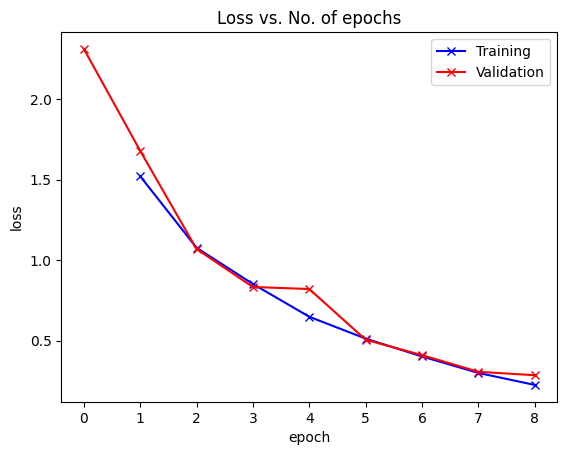

In [ ]:
plot_losses(history)

It's clear from the trend that our model isn't overfitting to the training data just yet. Try removing batch normalization, data augmentation and residual layers one by one to study their effect on overfitting.

Finally, let's visualize how the learning rate changed over time, batch-by-batch over all the epochs.

In [ ]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

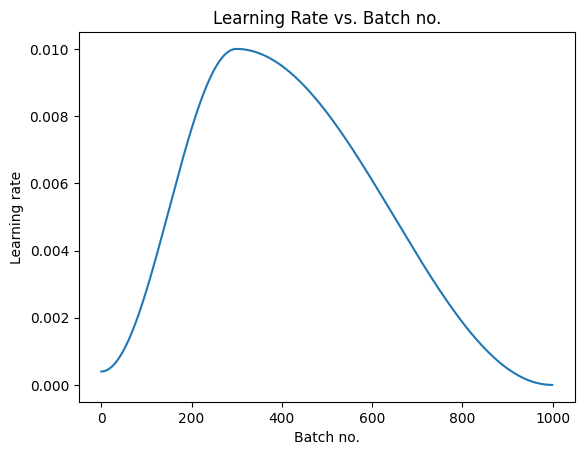

In [ ]:
plot_lrs(history)

As expected, the learning rate starts at a low value, and gradually increases for 30% of the iterations to a maximum value of `0.01`, and then gradually decreases to a very small value.

## Save

In [ ]:
torch.save(model.state_dict(), 'cifar10-resnet9.pth')